# Part 2: Observations & Predictions

In this notebook, we will see how you can select and use observations and predictions.

# In a nutshell

In [1]:
import numpy as np

from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import rail_from_manual_specifications_generator

In [2]:
from flatland.core.env_observation_builder import ObservationBuilder

# Observations are fully customizable
class SimpleObs(ObservationBuilder):
    """
    Simplest observation builder. The object returns observation vectors with 5 identical components,
    all equal to the ID of the respective agent.
    """

    def reset(self):
        return

    def get(self, handle):
        observation = handle * np.ones(5)
        return observation

In [3]:
# Create a fixed railway from a 2D array of (tile type, rotation) tuples
specs = [[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (7, 0), (0, 0)],
         [(7, 270), (1, 90), (1, 90), (1, 90), (2, 90), (7, 90)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]]

rail_shape = np.array(specs).shape

fixed_env = RailEnv(width=rail_shape[1],
              height=rail_shape[0],
              rail_generator=rail_from_manual_specifications_generator(specs),
              number_of_agents=1,
                obs_builder_object=SimpleObs()
              )

# Call reset() to initialize the env
observation = fixed_env.reset()

agent_handle = 0
print('Agent {} observations:'.format(agent_handle))
agent_obs = observation[0][agent_handle]

agent_obs

Agent 0 observations:


array([0., 0., 0., 0., 0.])

In [4]:
from flatland.envs.observations import TreeObsForRailEnv
from flatland.core.grid.grid4_utils import get_new_position
from typing import List

class SingleAgentNavigationObs(ObservationBuilder):
    """
    We build a representation vector with 3 binary components, indicating which of the 3 available directions
    for each agent (Left, Forward, Right) lead to the shortest path to its target.
    E.g., if taking the Left branch (if available) is the shortest route to the agent's target, the observation vector
    will be [1, 0, 0].
    """

    def __init__(self):
        super().__init__()

    def reset(self):
        pass

    def get(self, handle: int = 0) -> List[int]:
        agent = self.env.agents[handle]

        if agent.position:
            possible_transitions = self.env.rail.get_transitions(*agent.position, agent.direction)
        else:
            possible_transitions = self.env.rail.get_transitions(*agent.initial_position, agent.direction)

        num_transitions = np.count_nonzero(possible_transitions)

        # Start from the current orientation, and see which transitions are available;
        # organize them as [left, forward, right], relative to the current orientation
        # If only one transition is possible, the forward branch is aligned with it.
        if num_transitions == 1:
            observation = [0, 1, 0]
        else:
            min_distances = []
            for direction in [(agent.direction + i) % 4 for i in range(-1, 2)]:
                if possible_transitions[direction]:
                    new_position = get_new_position(agent.position, direction)
                    min_distances.append(
                        self.env.distance_map.get()[handle, new_position[0], new_position[1], direction])
                else:
                    min_distances.append(np.inf)

            observation = [0, 0, 0]
            observation[np.argmin(min_distances)] = 1

        return observation

In [5]:
from flatland.envs.rail_generators import complex_rail_generator

rails_generator = complex_rail_generator(nr_start_goal=5, nr_extra=1, min_dist=8, max_dist=99999,seed=1)

env = RailEnv(width=10, height=10,
              rail_generator=rails_generator, 
              number_of_agents=1, 
              obs_builder_object=SingleAgentNavigationObs())

obs, info = env.reset()

In [6]:
import PIL
from flatland.utils.rendertools import RenderTool

# Render the environment
def render_env(env):
    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)
    return image

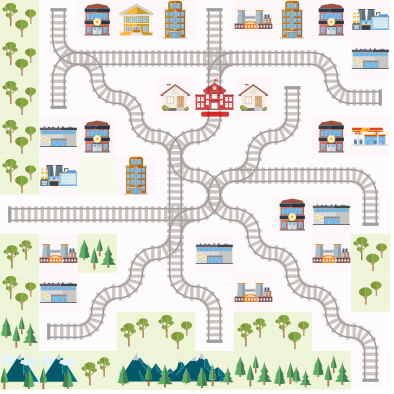

In [16]:
render_env(env);

In [17]:
directions = {0: 'left', 1: 'forward', 2: 'right'}

print("Directions of shortest paths")

# direction of the shortest path
def directions_on_shortest_paths(obs):
    for agent_handle in obs:
        shortest_directions = ""
        for idx, shortest in enumerate(obs[agent_handle]):
            if shortest:
                shortest_directions += directions[idx]

        print('Agent {}: {}'.format(agent_handle, shortest_directions))
    
directions_on_shortest_paths(obs)


Directions of shortest paths
Agent 0: forward


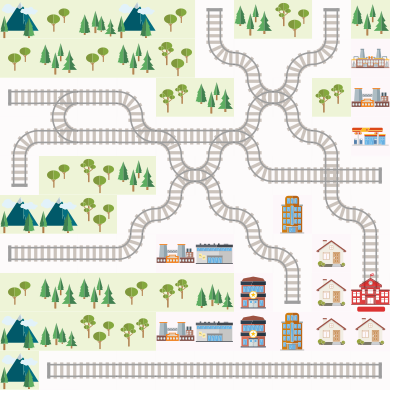

All done!


In [18]:
from IPython.display import clear_output

obs = env.reset()

# act in a direction that is on a shortest path
for step in range(150):
    action = np.argmax(obs[0])+1
    
    obs, all_rewards, done, _ = env.step({0: action})
    directions_on_shortest_paths(obs)
    print("Action: ", action, "Rewards: ", all_rewards, "  [done=", done, "]")
    
    clear_output(wait=True)
    render_env(env)
    
    if done['__all__']:
        print("All done!")
        break

In [ ]:
import imageio
from IPython.display import clear_output, Image

anim_path = 'assets/movie.gif'

obs = env.reset()

with imageio.get_writer(anim_path, mode='I') as writer:

    # act in a direction that is on a shortest path
    for step in range(150):
        action = np.argmax(obs[0])+1

        obs, all_rewards, done, _ = env.step({0: action})
        directions_on_shortest_paths(obs)
        print("Action: ", action, "Rewards: ", all_rewards, "  [done=", done, "]")

        clear_output(wait=True)
        image = render_env(env)
        
        writer.append_data(image)

        if done['__all__']:
            clear_output(wait=True)
            print("All done!")
            break

Image(url=anim_path)

Animated rendering
---

We will use [ipycanvas](https://github.com/martinRenou/ipycanvas) to cleanly display the environment in the notebook.
Note that Flatland comes with multiple rendering options.

In [11]:
from ipycanvas import Canvas

In [12]:
from flatland.utils.rendertools import AgentRenderVariant

env_renderer = render_pil = RenderTool(env, gl="PILSVG",
                                       agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                                       show_debug=False,
                                       screen_height=1000,  # Adjust these parameters to fit your resolution
                                       screen_width=1300)  # Adjust these parameters to fit your resolution

env_renderer.reset()

In [13]:
render_pil.render_env(show=False, show_observations=False, show_predictions=False, show_agents=True)
img = render_pil.get_image()

canvas = Canvas(size=(img.shape[0], img.shape[1]))
canvas.put_image_data(img)

In [14]:
canvas

Canvas(height=664, width=664)